In [62]:
import sqlite3
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from pathlib import Path
import statsmodels.api as sm
import plotly.express as px

def connect_to_database():
    db_folder = Path('database')
    conn = sqlite3.connect(db_folder / 'plants.db')
    return conn

def query_total_generation(conn):
    query = '''
        SELECT p.year_state, p.year, p.state_id, p.plfuelct,
        sum(p.PLGENATN) as total_non_renew_gen, sum(p.PLGENATR) as total_renew_gen
        FROM plants p
        GROUP BY p.year_state, p.year;
    '''
    data = pd.read_sql_query(query, conn)
    return data

def query_plant_types(conn):
    query = '''
        SELECT p.year_state, p.year, p.state_id, p.PLFUELCT,p.PLGENATN as renew_gen,p.PLGENATR as non_renew
        FROM plants p;
    '''
    data2 = pd.read_sql_query(query, conn)
    return data2

def prep_line_chart(data2):
    plant_typesplotting = ['GAS', 'NUCLEAR', 'COAL', 'WIND', 'SOLAR']
    RenewableGeneration = "renew_gen"
    NonRenewableGeneration = "non_renew"

    data2['plant_type'] = 'OTHER SOURCES'

    for index, row in data2.iterrows():
        if row['plfuelct'] in plant_typesplotting:
            data2.at[index, 'plant_type'] = row['plfuelct']

    data2['total_generation'] = data2[RenewableGeneration] + data2[NonRenewableGeneration]
    data2['total_generation_year'] = data2.groupby('year')['total_generation'].transform('sum')

    counts = data2.groupby(['year', 'plant_type'])['total_generation'].\
    sum().reset_index(name='total_generation_plant_type')
    counts['percentage'] = (counts['total_generation_plant_type'] / \
                            counts.groupby('year')['total_generation_plant_type'].transform('sum')) * 100
    return counts

def create_line_chart(counts, plant_typesplotting):
    fig = px.line(counts, x='year', y='percentage', color='plant_type', markers=True, line_shape='linear',
                category_orders={'plant_type': plant_typesplotting},
                color_discrete_sequence=px.colors.qualitative.G10)

    fig.update_layout(title='Percentage of Total Plants for Each Plant Type Over the Years',
                    xaxis_title='Year',
                    yaxis_title='Percentage of Total Plants',
                    legend_title='Plant Type',
                    yaxis=dict(tickformat=""),
                    plot_bgcolor='white',
                    xaxis=dict(
                        showline=True,
                        showgrid=False,
                        showticklabels=True,
                        linecolor='black',
                        linewidth=2,
                        ticks='outside',
                        tickfont=dict(
                            family='Arial',
                            size=12,
                            color='black',
                        )),
                        width=1100, 
                        height=600)

    fig.show()

def prediction_data_prep(data):

    RenewableGeneration = "total_renew_gen"
    NonRenewableGeneration = "total_non_renew_gen"
    total_generation_column = "total_generation"

    data[total_generation_column] = data[RenewableGeneration] + data[NonRenewableGeneration]


    data["PercentageRenewable"] = (data[RenewableGeneration] / data[total_generation_column]) * 100
    data["PercentageNonRenewable"] = (data[NonRenewableGeneration] / data[total_generation_column]) * 100
    data = data[data['state_id'] != 'PR']

    return data


def create_treemap(raw_df,given_type, year):
    grouped_data = raw_df.groupby(['year', 'state_id', 'plant_type']).size().reset_index(name='count')
    given_type = given_type
    given_typedf = grouped_data[grouped_data['plant_type'] == given_type]
    fig = px.treemap(given_typedf[given_typedf['year'] == year],
                     path=['state_id'],
                     values='count',
                     title=f'{given_type} Plants in {year} by State',
                     color='count',
                     color_continuous_scale='Viridis',
                     hover_data=['count'])  

    total_count = given_typedf[given_typedf['year'] == year]['count'].sum()

    fig.add_annotation(
        x=0.5,
        y=.92,
        text=f'Total: {total_count}',
        showarrow=True,
        font=dict(size=25)
    )

    fig.show()

def predict_renewable_energy(data, percent_required):
    results = []

    grouped_data = data.groupby('state_id')
    for state, state_data in grouped_data:
        if state_data["PercentageRenewable"].iloc[-1] < percent_required:
            train_data, test_data = train_test_split(state_data, test_size=0.2, random_state=100)
            X_train = train_data[['PercentageRenewable']]
            y_train = train_data['year']
            X_train = sm.add_constant(X_train)
            model = sm.OLS(y_train, X_train).fit()
            X_test = sm.add_constant(test_data[['PercentageRenewable']])
            y_pred = model.predict(X_test)
            p_value = model.pvalues['PercentageRenewable']
            predicted_year = round(model.predict([1, percent_required])[0])
            statistically_significant = 'Yes' if p_value < 0.05 else 'No'
            current_year = pd.to_datetime('today').year

            if predicted_year >= current_year:
                statistically_significant = 'Yes' if p_value < 0.05 else 'No'
                results.append({'state_id': state, 'predicted_year': int(predicted_year),
                                'statistically_significant': statistically_significant})
            else:
                statistically_significant = 'Yes' if p_value < 0.05 else 'No'
                predicted_year = 'Not predictable'
                results.append({'state_id': state, 'predicted_year': predicted_year,
                                'statistically_significant': statistically_significant})
        else:
            results.append({'state_id': state, 'predicted_year': 'Already there!',
                            'statistically_significant': statistically_significant})

    results_df = pd.DataFrame(results)
    results_df.to_csv('place_holder_predictions.csv')
    return results_df

def run():
    conn = connect_to_database()
    data = query_total_generation(conn)
    data2 = query_plant_types(conn)
    conn.close()
    plant_typesplotting = ['GAS', 'NUCLEAR', 'COAL', 'WIND', 'SOLAR']
    
    counts = prep_line_chart(data2)
    create_line_chart(counts,plant_typesplotting )



    for year in [2004, 2014, 2022]:
        create_treemap(data2 ,"COAL",year)
    percentage = 60
    predict_df = prediction_data_prep(data)
    results_df = predict_renewable_energy(predict_df,percentage)
    print(results_df)



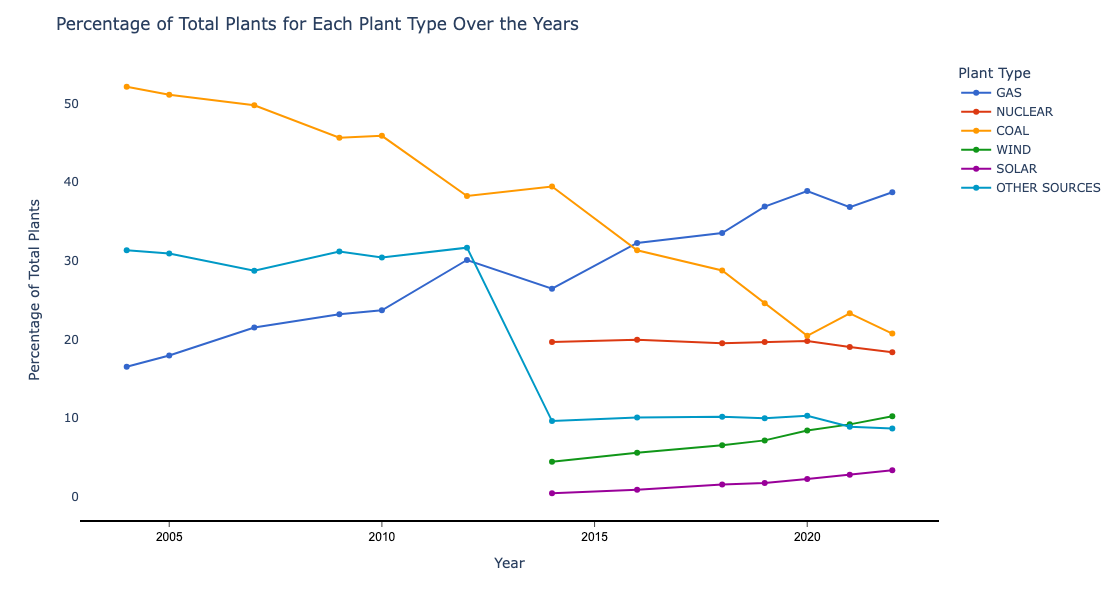

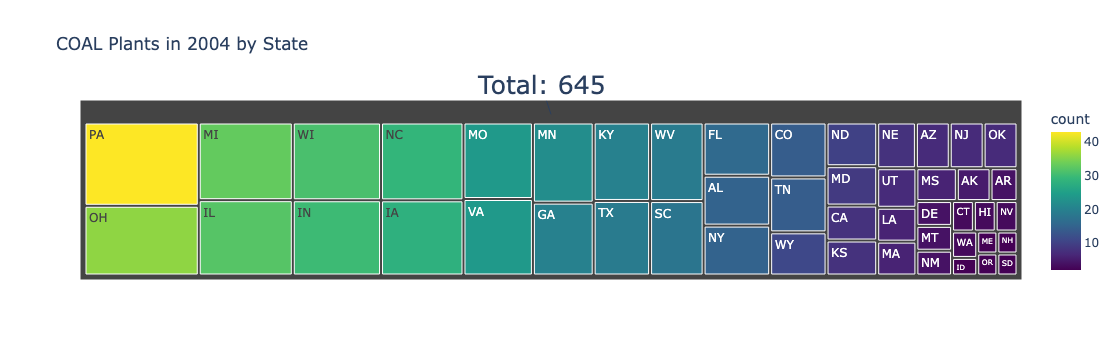

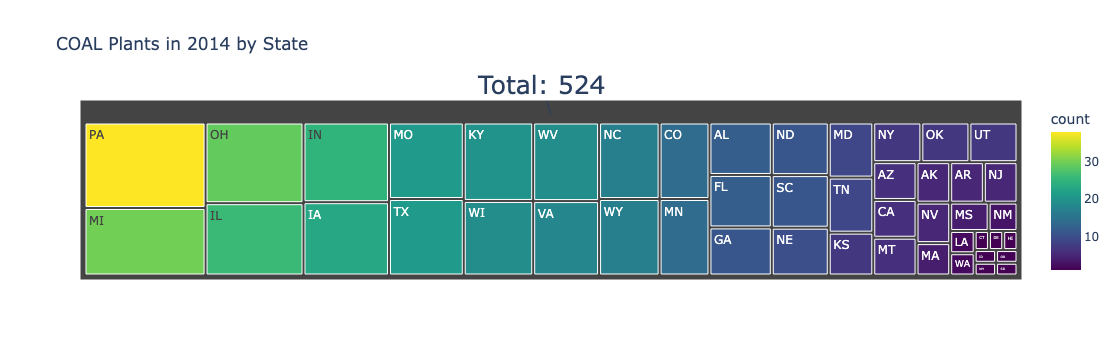

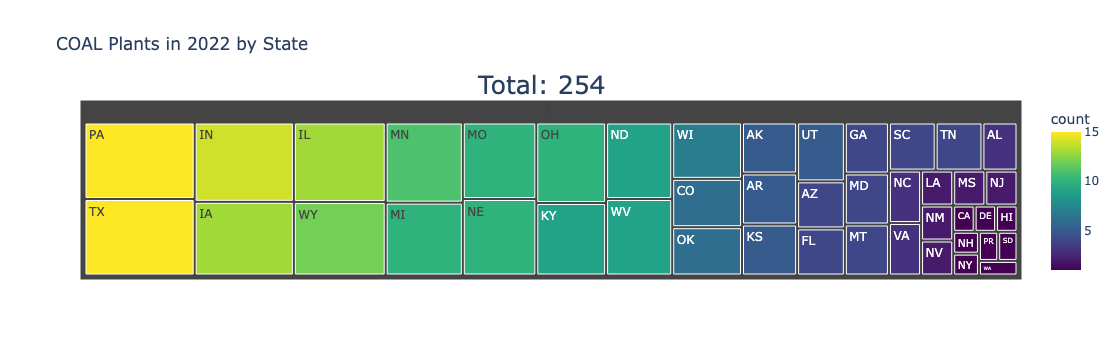

   state_id   predicted_year statistically_significant
0        AK             2056                       Yes
1        AL             2068                        No
2        AR  Not predictable                        No
3        AZ             2111                       Yes
4        CA             2030                       Yes
5        CO             2037                       Yes
6        CT             2049                        No
7        DC  Not predictable                       Yes
8        DE             2270                       Yes
9        FL             2217                       Yes
10       GA             2107                       Yes
11       HI             2070                       Yes
12       IA   Already there!                       Yes
13       ID   Already there!                       Yes
14       IL             2087                       Yes
15       IN             2099                       Yes
16       KS             2026                       Yes
17       K

In [63]:
run()

In [1]:
import sqlite3
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from pathlib import Path
import matplotlib.pyplot as plt 
import statsmodels.api as sm

In [51]:
db_folder = Path('database')

conn = sqlite3.connect(db_folder / 'plants.db')
query = '''
    SELECT p.year_state, p.year, p.state_id,
    sum(p.PLGENATN) as total_non_renew_gen, sum(p.PLGENATR) as total_renew_gen
    FROM plants p
    GROUP BY p.year_state, p.year;
'''

data = pd.read_sql_query(query, conn)

conn.close()

In [18]:
db_folder = Path('database')

conn = sqlite3.connect(db_folder / 'plants.db')

query = '''
    SELECT p.year_state, p.year, p.state_id, p.PLFUELCT,p.PLGENATN as renew_gen,p.PLGENATR as non_renew
    FROM plants p;
'''

data2 = pd.read_sql_query(query, conn)

conn.close()

In [23]:
import numpy as np
import pandas as pd

plant_typesplotting = ['GAS', 'NUCLEAR', 'COAL', 'WIND', 'SOLAR']
RenewableGeneration = "renew_gen"
NonRenewableGeneration = "non_renew"
state_column = "state_id"
year_column = "year"
total_generation_column = "total_generation"

data2['plant_type'] = 'OTHER SOURCES'

for index, row in data2.iterrows():
    if row['plfuelct'] in plant_typesplotting:
        data2.at[index, 'plant_type'] = row['plfuelct']

data2['total_generation'] = data2[RenewableGeneration] + data2[NonRenewableGeneration]
data2['total_generation_year'] = data2.groupby('year')['total_generation'].transform('sum')

counts = data2.groupby(['year', 'plant_type'])['total_generation'].\
sum().reset_index(name='total_generation_plant_type')
counts['percentage'] = (counts['total_generation_plant_type'] / \
                        counts.groupby('year')['total_generation_plant_type'].transform('sum')) * 100




In [24]:
counts


,year,plant_type,total_generation_plant_type,percentage
0,2004,COAL,2.051983e+09,52.145999
1,2004,GAS,6.495443e+08,16.506544
2,2004,OTHER SOURCES,1.233545e+09,31.347457
3,2005,COAL,2.074026e+09,51.129192
4,2005,GAS,7.282494e+08,17.952910
5,2005,OTHER SOURCES,1.254167e+09,30.917898
6,2007,COAL,2.071651e+09,49.786115
7,2007,GAS,8.944949e+08,21.496586
8,2007,OTHER SOURCES,1.194956e+09,28.717300
9,2009,COAL,1.803765e+09,45.652241


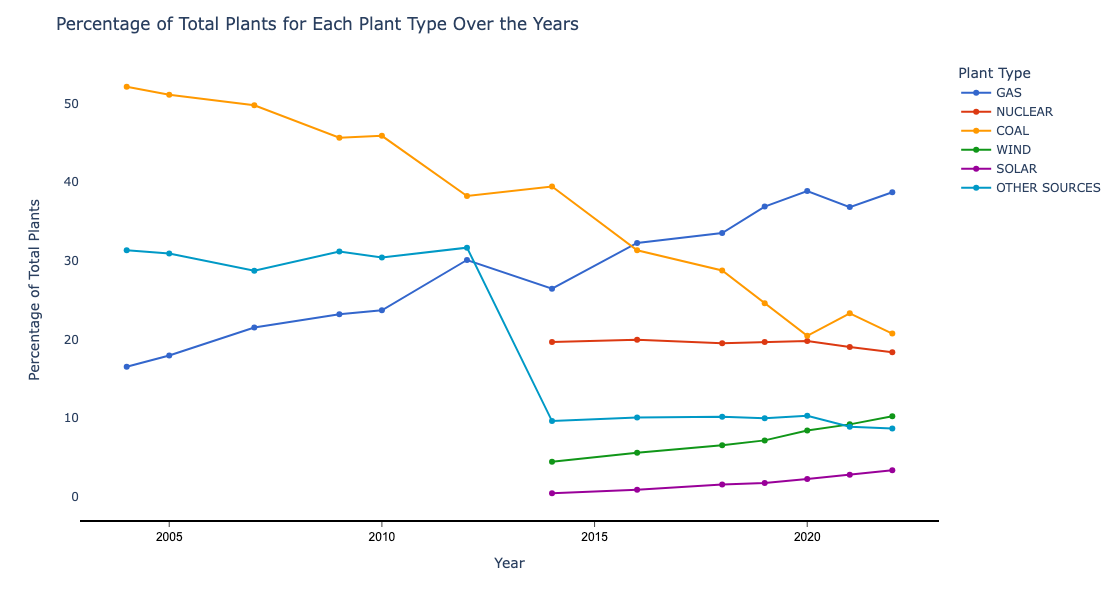

In [26]:
import plotly.express as px

fig = px.line(counts, x='year', y='percentage', color='plant_type', markers=True, line_shape='linear',
              category_orders={'plant_type': plant_typesplotting},
              color_discrete_sequence=px.colors.qualitative.G10)

fig.update_layout(title='Percentage of Total Plants for Each Plant Type Over the Years',
                  xaxis_title='Year',
                  yaxis_title='Percentage of Total Plants',
                  legend_title='Plant Type',
                  yaxis=dict(tickformat=""),
                  plot_bgcolor='white',
                  xaxis=dict(
                    showline=True,
                    showgrid=False,
                    showticklabels=True,
                    linecolor='black',
                    linewidth=2,
                    ticks='outside',
                    tickfont=dict(
                        family='Arial',
                        size=12,
                        color='black',
                    )),
                    width=1100, 
                    height=600)

fig.show()


In [28]:
grouped_data

,year,state_id,plant_type,count
0,2004,AK,COAL,5
1,2004,AK,GAS,9
2,2004,AK,OTHER SOURCES,89
3,2004,AL,COAL,15
4,2004,AL,GAS,23
...,...,...,...,...
2730,2022,WY,COAL,12
2731,2022,WY,GAS,8
2732,2022,WY,OTHER SOURCES,21
2733,2022,WY,SOLAR,1


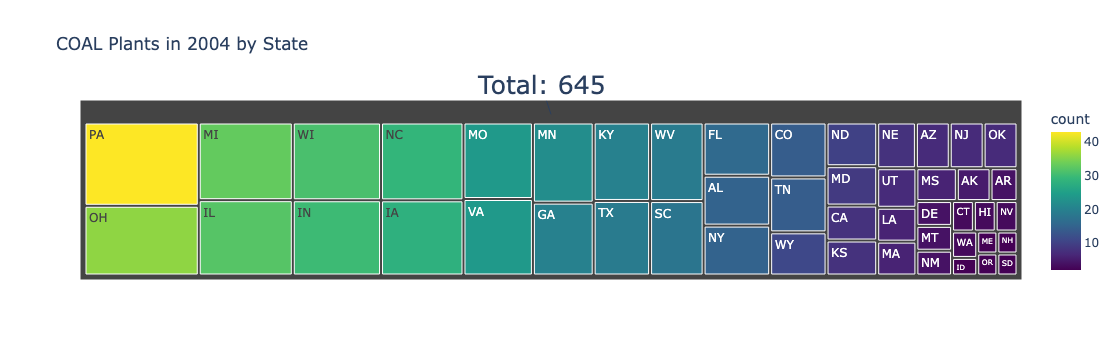

In [34]:
import plotly.express as px



def create_treemap(raw_df,given_type, year):
    grouped_data = raw_df.groupby(['year', 'state_id', 'plant_type']).size().reset_index(name='count')
    given_type = given_type
    given_typedf = grouped_data[grouped_data['plant_type'] == given_type]
    fig = px.treemap(given_typedf[given_typedf['year'] == year],
                     path=['state_id'],
                     values='count',
                     title=f'{given_type} Plants in {year} by State',
                     color='count',
                     color_continuous_scale='Viridis',
                     hover_data=['count'])  

    total_count = given_typedf[given_typedf['year'] == year]['count'].sum()

    fig.add_annotation(
        x=0.5,
        y=.92,
        text=f'Total: {total_count}',
        showarrow=True,
        font=dict(size=25)
    )

    fig.show()

create_treemap(data2,"COAL",2004)


In [55]:
data = data[data['state_id'] != 'PR']

In [41]:
data2

,year_state,year,state_id,plfuelct,renew_gen,non_renew,plant_type,total_generation,total_generation_year
0,2012_AK,2012,AK,GAS,0.000,0.0,GAS,0.000,4.045518e+09
1,2012_AK,2012,AK,OIL,2031.000,0.0,OTHER SOURCES,2031.000,4.045518e+09
2,2012_AK,2012,AK,GAS,54633.000,0.0,GAS,54633.000,4.045518e+09
3,2012_AK,2012,AK,OIL,1765.000,0.0,OTHER SOURCES,1765.000,4.045518e+09
4,2012_AK,2012,AK,OIL,2759.000,0.0,OTHER SOURCES,2759.000,4.045518e+09
...,...,...,...,...,...,...,...,...,...
110446,2022_WY,2022,WY,WIND,0.000,341330.0,WIND,341330.000,4.240141e+09
110447,2022_WY,2022,WY,COAL,688614.004,0.0,COAL,688614.004,4.240141e+09
110448,2022_WY,2022,WY,COAL,720573.002,0.0,COAL,720573.002,4.240141e+09
110449,2022_WY,2022,WY,COAL,805208.002,0.0,COAL,805208.002,4.240141e+09


In [52]:
RenewableGeneration = "total_renew_gen"
NonRenewableGeneration = "total_non_renew_gen"
total_generation_column = "total_generation"
state_column = "state_id"
year_column = "year"

data[total_generation_column] = data[RenewableGeneration] + data[NonRenewableGeneration]


data["PercentageRenewable"] = (data[RenewableGeneration] / data[total_generation_column]) * 100
data["PercentageNonRenewable"] = (data[NonRenewableGeneration] / data[total_generation_column]) * 100

In [53]:
data

,year_state,year,state_id,total_non_renew_gen,total_renew_gen,total_generation,PercentageRenewable,PercentageNonRenewable
0,2004_AK,2004,AK,5.019477e+06,1.507234e+06,6.526711e+06,23.093320,76.906680
1,2004_AL,2004,AL,1.228036e+08,1.452449e+07,1.373281e+08,10.576485,89.423515
2,2004_AR,2004,AR,4.624578e+07,5.579443e+06,5.182522e+07,10.765883,89.234117
3,2004_AZ,2004,AZ,9.192974e+07,6.967969e+06,9.889771e+07,7.045633,92.954367
4,2004_CA,2004,CA,1.365880e+08,5.622154e+07,1.928096e+08,29.159101,70.840899
...,...,...,...,...,...,...,...,...
662,2022_VT,2022,VT,9.630800e+03,2.173006e+06,2.182637e+06,99.558754,0.441246
663,2022_WA,2022,WA,2.830033e+07,8.835030e+07,1.166506e+08,75.739237,24.260763
664,2022_WI,2022,WI,5.546563e+07,5.763137e+06,6.122877e+07,9.412467,90.587533
665,2022_WV,2022,WV,5.300100e+07,3.664359e+06,5.666536e+07,6.466665,93.533335


In [ ]:
percent = 60
percent_data = data[data['PercentageRenewable'] > percent]

In [ ]:
states = percent_data['state_id'].unique()
print(f"States with renewable energy production greater than {percent}% are: \n")
for state_id in states:
    print(abbreviation_to_state_name[state_id])

In [ ]:
abbreviation_to_state_name = {
    'AL': 'ALABAMA',
    'AK': 'ALASKA',
    'AZ': 'ARIZONA',
    'AR': 'ARKANSAS',
    'CA': 'CALIFORNIA',
    'CO': 'COLORADO',
    'CT': 'CONNECTICUT',
    'DC': 'DISTRICT OF COLUMBIA',
    'DE': 'DELAWARE',
    'FL': 'FLORIDA',
    'GA': 'GEORGIA',
    'HI': 'HAWAII',
    'ID': 'IDAHO',
    'IL': 'ILLINOIS',
    'IN': 'INDIANA',
    'IA': 'IOWA',
    'KS': 'KANSAS',
    'KY': 'KENTUCKY',
    'LA': 'LOUISIANA',
    'ME': 'MAINE',
    'MD': 'MARYLAND',
    'MA': 'MASSACHUSETTS',
    'MI': 'MICHIGAN',
    'MN': 'MINNESOTA',
    'MS': 'MISSISSIPPI',
    'MO': 'MISSOURI',
    'MT': 'MONTANA',
    'NE': 'NEBRASKA',
    'NV': 'NEVADA',
    'NH': 'NEW HAMPSHIRE',
    'NJ': 'NEW JERSEY',
    'NM': 'NEW MEXICO',
    'NY': 'NEW YORK',
    'NC': 'NORTH CAROLINA',
    'ND': 'NORTH DAKOTA',
    'OH': 'OHIO',
    'OK': 'OKLAHOMA',
    'OR': 'OREGON',
    'PA': 'PENNSYLVANIA',
    'RI': 'RHODE ISLAND',
    'SC': 'SOUTH CAROLINA',
    'SD': 'SOUTH DAKOTA',
    'TN': 'TENNESSEE',
    'TX': 'TEXAS',
    'UT': 'UTAH',
    'VT': 'VERMONT',
    'VA': 'VIRGINIA',
    'WA': 'WASHINGTON',
    'WV': 'WEST VIRGINIA',
    'WI': 'WISCONSIN',
    'WY': 'WYOMING'
}


In [ ]:

def get_slope_info(state_data):
    X = sm.add_constant(state_data[['year']])
    y = state_data['PercentageRenewable']

    model = sm.OLS(y, X).fit()

    slope = model.params['year']
    p_value = model.pvalues['year']

    if p_value < 0.05:
        sig = 'Yes'
    else:
        sig = 'No'

    return slope, sig

def get_slope_from_state(state):
    return slopes[state][0]

starting_year = 2018

grouped_data = data[data['year'] >= starting_year].groupby('state_id')

slopes = {state: get_slope_info(state_data) for state, state_data in grouped_data}

top_states = sorted(slopes, key=get_slope_from_state, reverse=True)

print(f"States with the highest improvement in renewable energy since {starting_year}:")
for state in top_states[:5]:
     print(f" {abbreviation_to_state_name[state]}: {round(slopes[state][0])}% increase per year")

In [59]:
    results = []
    data = data[data['state_id'] != 'PR']
    grouped_data = data.groupby('state_id')
percent_required = 60
    for state, state_data in grouped_data:
        if state_data["PercentageRenewable"].iloc[-1] < percent_required:
            train_data, test_data = train_test_split(state_data, test_size=0.2, random_state=100)
            X_train = train_data[['PercentageRenewable']]
            y_train = train_data['year']
            X_train = sm.add_constant(X_train)
            model = sm.OLS(y_train, X_train).fit()
            X_test = sm.add_constant(test_data[['PercentageRenewable']])
            y_pred = model.predict(X_test)
            p_value = model.pvalues['PercentageRenewable']
            predicted_year = round(model.predict([1, percent_required])[0])
            statistically_significant = 'Yes' if p_value < 0.05 else 'No'
            current_year = pd.to_datetime('today').year

            if predicted_year >= current_year:
                statistically_significant = 'Yes' if p_value < 0.05 else 'No'
                results.append({'state_id': state, 'predicted_year': int(predicted_year),
                                'statistically_significant': statistically_significant})
            else:
                statistically_significant = 'Yes' if p_value < 0.05 else 'No'
                predicted_year = 'Not predictable'
                results.append({'state_id': state, 'predicted_year': predicted_year,
                                'statistically_significant': statistically_significant})
        else:
            results.append({'state_id': state, 'predicted_year': 'already reached',
                            'statistically_significant': statistically_significant})

    results_df = pd.DataFrame(results)
    results_df.to_csv('place_holder_predictions.csv')
    results_df

,state_id,predicted_year,statistically_significant
0,AK,2056,Yes
1,AL,2068,No
2,AR,Not predictable,No
3,AZ,2111,Yes
4,CA,2030,Yes
5,CO,2037,Yes
6,CT,2049,No
7,DC,Not predictable,Yes
8,DE,2270,Yes
9,FL,2217,Yes
